In [1]:
# Run Functional connectivity on HBN data
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
#matplotlib.use('agg') # supposed to avoid memory leak - add to .py version of code when not running as notebook
#load_ext memory_profiler

In [3]:
# Load subject fmri data
# This will loop across subjects
projectdir = '/scratch/groups/jyeatman/HBN_FC/'
inputdir = projectdir + 'input'
#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.basename(x) for x in glob.glob(inputdir + '/sub-*')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')

Found 262 subjects in inputdir


In [6]:
subs

['sub-NDARYE379GGT',
 'sub-NDARWP817CVB',
 'sub-NDARFR820KFF',
 'sub-NDARJJ277JP3',
 'sub-NDARBU730PN8',
 'sub-NDARKR155ME9',
 'sub-NDARXE193CZ1',
 'sub-NDARPE752VYE',
 'sub-NDARHR753ZKU',
 'sub-NDARNK740ZVM',
 'sub-NDARDR439HY2',
 'sub-NDARBR740NKV',
 'sub-NDARYE221LZB',
 'sub-NDARMT661WCR',
 'sub-NDARCG785NND',
 'sub-NDARJL303FKR',
 'sub-NDARVC195NLH',
 'sub-NDARBF851NH6',
 'sub-NDARWP732GD1',
 'sub-NDARCM302VJ1',
 'sub-NDARBN620TT7',
 'sub-NDARRL315KV3',
 'sub-NDARWE898TG8',
 'sub-NDARMT784NED',
 'sub-NDARYK164AEJ',
 'sub-NDARDD854GF8',
 'sub-NDARNZ141GNH',
 'sub-NDARYM063XB8',
 'sub-NDARGZ553TMQ',
 'sub-NDARTF781TM8',
 'sub-NDARUV041YCY',
 'sub-NDARDP786HE6',
 'sub-NDARMA449YB6',
 'sub-NDARGR893PUA',
 'sub-NDARMB216LA6',
 'sub-NDARJZ274PRQ',
 'sub-NDARPF459CME',
 'sub-NDARJZ167VEZ',
 'sub-NDARHG188YE9',
 'sub-NDARTW850GHU',
 'sub-NDARTU777GVV',
 'sub-NDARAD615WLJ',
 'sub-NDARPH176EWC',
 'sub-NDARJR473HXT',
 'sub-NDARYM586MYN',
 'sub-NDARFV061AR5',
 'sub-NDAREV342ABE',
 'sub-NDARAY2

In [3]:
# Where to save outputs: 
surfacedir = projectdir + 'surface/statMaps/'
imagedir =  projectdir + 'surface/images/'

if not os.path.exists(surfacedir):
    os.makedirs(surfacedir)

if not os.path.exists(imagedir):
    os.makedirs(imagedir)
    
# Paths to surface ROIs from Kalanit's group - Rosenke 2021
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/FreeSurfer/'
roi_names = ['MPM_lh_OTS.label','MPM_lh_pOTS.label']

# Paths to surface ROIs based on Gari's coordinates (Lerma-Usabiaga PNAS 2018, converted vol2surf)
roidir =  '/home/groups/jyeatman/ROI_Atlases/'
roi_names = ['VWFA1.label.gii','VWFA2.label.gii']

# Paths to surface ROIs from Emily
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label','MPM_lh_IOS.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

# Which task
task = 'movie' # options are 'rest' or 'movie'
hemi = 'left'
# which correlation to save
corr_type = 'fisherz' # options are 'rval', 'fisherz'

overwrite = False
createFigs = False # create connectiovity maps per subject
saveFigs = False # Save png files of connectivity maps
saveMaps = False # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = True

# Run on a subset of data for debugging
subs = ['sub-NDARAC349YUC']

droptp = [0,1,2,3,4,5]
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Load subject list
subject_file = projectdir+ 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
if task == 'rest':
    subject_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
elif task == 'movie':
    subject_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'
sub_list = pd.read_csv(subject_file)
subs = sub_list['participant_id']
#subs = subs[0:3]
sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

Running on 120 subjects


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


In [4]:
# try to turn into separate functions modularize code and test each part

Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARAA948VFH_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 0
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARAC350BZ0_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 1
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARAD615WLJ_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 2
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARBF851NH6_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 3
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARBJ159HXB_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 4
Calculating mean connectivity 

Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARKV807EMJ_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 49
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARKX788PHG_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 50
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARKZ312XR1_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 51
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARLG154ZA3_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 52
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARLM196YRG_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 53
Calculating mean connectivity for lh_pOTS_chars.label
/

Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARWN691CG7_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 94
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARWP732GD1_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 95
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARWR247CE1_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 96
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARWT449PUN_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 97
Calculating mean connectivity for lh_pOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARXB889WUB_task-movie_lh_pOTS_chars.labelfisherz.npy exists, 
skipping sub # 98
Calculating mean connectivity for lh_pOTS_chars.label
/

Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARFA737TG6_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 21
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARFB969EMV_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 22
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARFE163HVN_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 23
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARFG713PLR_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 24
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARFG851ZNZ_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 25
Calculating mean connectivity for lh_mOTS_chars.label
/

Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARRC295CHW_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 69
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARRP163YRC_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 70
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARRP818DWL_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 71
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARRU290EZV_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 72
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARRU979UBW_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 73
Calculating mean connectivity for lh_mOTS_chars.label
/

Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARZF170TZ0_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 113
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARZJ587UZU_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 114
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARZJ603JM0_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 115
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARZM903TNL_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 116
Calculating mean connectivity for lh_mOTS_chars.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARZT940RZG_task-movie_lh_mOTS_chars.labelfisherz.npy exists, 
skipping sub # 117
Calculating mean connectivity for lh_mOTS_chars.la

Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARJA788CH7_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 37
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARJC010YYF_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 38
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARJC559WW5_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 39
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARJF517HC8_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 40
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARJJ277JP3_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 41
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/su

Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARUT470BM4_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 82
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARUT891XYJ_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 83
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARUV041YCY_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 84
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARUV263YB5_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 85
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/sub-NDARUX216VHK_task-movie_MPM_lh_IOS.labelfisherz.npy exists, 
skipping sub # 86
Calculating mean connectivity for MPM_lh_IOS.label
/scratch/groups/jyeatman/HBN_FC/su

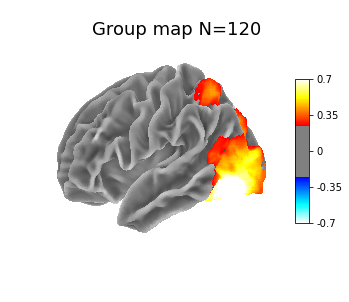

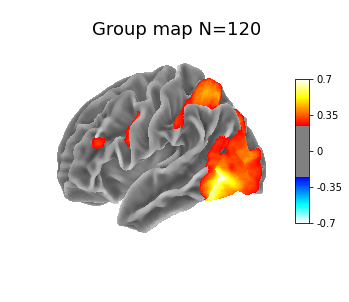

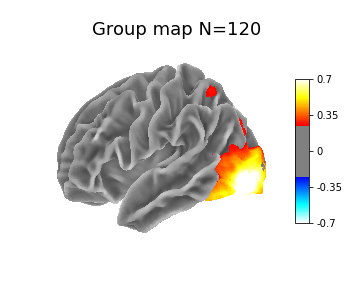

In [5]:
# Try loading a gii surface file that was previously saved
for rr in range(len(roi_names)):
    # Allocate empty array for group data - N subjects * n vertices
    # We create a blank group_map here to avoid data bleeding from ROI to ROI in case there are missing values 
    group_map = np.zeros(shape = (len(subs),white_left[0].shape[0]))
    
    # Load ROI
    cur_roi = surface.load_surf_data(roidir + roi_names[rr])
    cur_roi = cur_roi.astype(int) 
    print('Analyzing ROI ' + roidir + roi_names[rr])
    
    # Loop over subjects and compute connectivity for that ROI
    for ii in range(len(subs)):  
        sub_dir = (inputdir + subs.iloc[ii]) # maybe we won't use sub_dir for anything? 
        func_file = subs.iloc[ii] + '_task-' + task + '.gii'
        if not exists(projectdir + func_file):
            print('Cant find ' + func_file)
            continue
        
        output_subfilename = surfacedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + corr_type + '.npy'
        if os.path.exists(output_subfilename):
            print(output_subfilename +' exists, \nskipping sub # ' + str(ii))
            stat_map = np.load(output_subfilename)
            group_map[ii,:] = stat_map 
        else:
            print('Loading sub # ' + str(ii) + ' ' + func_file)
            run_data = surface.load_surf_data(projectdir + func_file)
            # saving as gii and loading the surface seems to transpose the data
            # we want our data to be vertices * timepoints
            if run_data.shape[0] < run_data.shape[1]:
                run_data = np.transpose(run_data)
            print('Original Data Vertices by Timepoints')
            print(run_data.shape) 
            # we want to drop the same volumes from the second run as well - only for resting state
            if task =='rest':
                droptp2 = [x + int(run_data.shape[1]/2) for x in droptp]
                dropall = droptp + droptp2
                print('dropping volumes: ' + str(dropall))

            elif task == 'movie':
                dropall = droptp
                print('dropping volumes: ' + str(dropall))

            run_data = np.delete(run_data,dropall,axis=1)
            print('After dropping initial 6 Timepoints, Vertices by Timepoints')
            print(run_data.shape) 
            # TBD - implement scrubbing

            # Compute the mean time series for the ROI
            seed_timeseries = np.nanmean(run_data[cur_roi], axis=0)
            # To plot mean timeseries:
            # fig, ax = plt.subplots(figsize =(4, 3))
            # ax.plot(seed_timeseries)
            # ax.set_title('Seed timeseries ' + subs.iloc[ii] + ' ' + roi_names[rr])
            # ax.set_xlabel('Volume number')
            # ax.set_ylabel('Normalized signal')
            # print()

            # Compute correlations between the seed timeseries and each vertex
            stat_map = np.zeros(run_data.shape[0])
            for i in range(run_data.shape[0]): # this loops through the vertices
                stat_map[i] = stats.pearsonr(seed_timeseries, run_data[i])[0]

            print('computing stat_map ' + subs.iloc[ii])
            if corr_type == 'fisherz':
            # Fisher transform the map
                stat_map = np.arctanh(stat_map)

            # Save as a gifti that could be loaded into freeview
            if saveMaps:
                targetFile = surfacedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + corr_type + '.curv'
                if not os.path.exists(targetFile):
                    nib.freesurfer.io.write_morph_data(targetFile,stat_map)

            # Add the stat map to the group stat map
            group_map[ii,:] = stat_map 

            # Save individual correlation maps - this way we can use a csv with 
            # a list of subjects and create a group npy from selected subjects
            output_subfilename = surfacedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + corr_type
            np.save(output_subfilename,stat_map)

            # Plot the seed-based connectivity
            figTitle = subs.iloc[ii] + ' ' + roi_names[rr]
            output_subfilename = imagedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + corr_type

            if createFigs:
                if saveFigs:
                    output_filel = output_subfilename + '_lateral.png'
                    output_filev = output_subfilename + '_ventral.png'
                    print('Saving ' + output_filel)
                else: 
                    output_filel = None
                    output_filev = None

                plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
                hemi='left', threshold = .3, vmax=0.7, view='lateral', colorbar=True,
                bg_map=fsaverage['curv_left'], title=figTitle, output_file = output_filel)
                print()
                #plt.close()

                plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
                hemi='left', threshold = .3, vmax=0.7, view='ventral', colorbar=True,
                bg_map=fsaverage['curv_left'], title=figTitle, output_file = output_filev)
                print()
                #plt.close()

    #         # save intermediate map of mean connectivity as we add more subjects

        print('Calculating mean connectivity for ' + roi_names[rr])
        #if ii > 0:
            #mid_group_mean = np.mean(group_map[0:ii,:], axis = 0)

            #mid_groupfilename = surfacedir + 'mid_GroupMap_task-' + task + '_' + roi_names[rr] + '_N' + str(ii) + '_lateral.png'
            #save also as numpy array
           # np.save(mid_groupfilename[:-12],group_map)
            
            
    # outside the subject loop, save map of mean connectivity across the entire sample
    print('Calculating mean connectivity for ' + roi_names[rr])
    group_mean = np.mean(group_map, axis = 0)

    # Save map of group mean
    if saveFigs:
        output_file = output_groupfilename+ '_lateral.png'
    else:
        output_file = None

    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=group_mean,
    hemi='left', threshold = .25, vmax=0.7, view='lateral', colorbar=True,
    bg_map=fsaverage['curv_left'],title='Group map N=' + str(len(subs)), output_file = output_file)
  #  plt.close()
    
    if saveGroup:
        output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[rr] + '_N' + str(len(subs)) + '_' + corr_type
        nib.freesurfer.io.write_morph_data(output_groupfilename+ '.curv',group_mean)        
        #save also as numpy array
        np.save(output_groupfilename,group_map)

[ 0.24865034  0.2105941   0.01942892 ...  0.04546965  0.05586662
 -0.02182745]


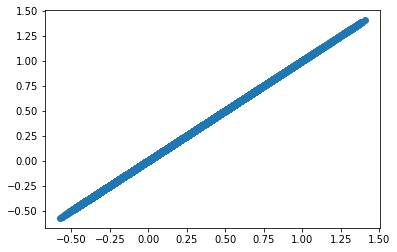

In [27]:
# Test assignment of subject map to group map
test_ind  = 145
roi_ind = 0
output_subfilename = surfacedir + subs.iloc[test_ind] + '_task-' + task + '_' + roi_names[roi_ind] + corr_type + '.npy'
test_sub = np.load(output_subfilename)
print(test_sub)

output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[roi_ind] + '_N' + str(224) + '_' + corr_type + '.npy'
test_group = np.load(output_groupfilename)
test_group[test_ind]
plt.scatter(test_sub,test_group[test_ind])